In [28]:
import h5py
import gurobipy as gp
from gurobipy import GRB
import numpy as np

from matplotlib import pyplot as plt

### Model for Q1 and Q2

In [29]:
def dist(c_i, c_j):
    return np.linalg.norm(c_i - c_j)

In [30]:
def model1(N, d_max, n_min, n_max, pairings, distances):
    m = gp.Model('milp')

    m.Params.LogToConsole = 0   # comment to show the log of optimization results
    
    M = 1000000000

    # decision variables
    D_k = m.addVars(range(N), vtype='B', name='D_k')
    a_ik = m.addVars(pairings.keys(), vtype='B', name='a_ik')
    w_ij = m.addVars(distances.keys(), vtype='B', name='w_ij')

    # objective function
    obj_fun = D_k.sum()
    m.setObjective(obj_fun, GRB.MINIMIZE)

    # constraints
    # 1. each client is assigned to one and only one depot
    m.addConstrs((a_ik.sum(client, "*") == 1
                for client in range(N)),
                name="unique assignment")
                
    # 2. lower/upper bound of the number of clients in one depot
    for k in range(N):
        m.addConstr(a_ik.sum('*', k) <= D_k[k] * n_max)

    for k in range(N):
        m.addConstr(a_ik.sum('*', k) >= D_k[k] * n_min)

    # 3. distance requirement
    for k in range(N):
        for i in range(N):
            for j in range(i+1, N):
                m.addConstr(d_max >= distances[i, j] - M * (1 - w_ij[i, j]))
                m.addConstr(a_ik[i, k] + a_ik[j, k] <=  1 + M * w_ij[i, j])
    
    m.update()
    return m

In [31]:
def solveModel(m):
    m.optimize()

In [32]:
from collections import defaultdict

def analyzeModel(m):
    minNumDepot = m.ObjBound

    re = defaultdict(list)
    if minNumDepot != float('inf'):
        for v in m.getVars():  
            if v.varName[0] == 'a' and int(v.x) == 1:
                pair = v.varName[5:len(v.varName)-1].split(',')
                client, depot = int(pair[0]), int(pair[1])
                re[depot].append(client)

    return minNumDepot, re

### Q1

In [33]:
# read data and set the variables

data = {1: ["X1-3.jld", 10, 2, 8], 2: ["X2-2.jld", 9, 4, 6], 3: ["X3-2.jld", 9, 4, 6]}

In [39]:
def q1(instance_id):
    # change date[i] to select the instance
    instance, d_max, n_min, n_max = data[instance_id]

    f = h5py.File(instance, 'r')
    X = np.transpose(f['X'])

    N = len(X)

    distances = {(client1, client2): dist(X[client1], X[client2]) for client1 in range(N) for client2 in range(client1+1, N)}
    pairings = {(client, depot): 0 for client in range(N) for depot in range(N)}

    model = model1(N, d_max, n_min, n_max, pairings, distances)
    solveModel(model)
    minNumDepot, assignment = analyzeModel(model)
    
    if minNumDepot == float('inf'):
        print('No Feasible Solution for instance %d' % instance_id)
        return

    plt.title('Depot Assignment for Instance %d' % instance_id)
    for depot, clients in assignment.items():
        print(depot, clients)
        plt.xlabel('x-coordinate of clients')
        plt.ylabel('y-coordinate of clients')
        plt.scatter(X[clients][:, 0], X[clients][:, 1])

    plt.show()
    return

3 [0, 1, 2, 3]
1 [4, 6, 9, 13, 14, 16, 19]
2 [5, 7, 8, 10, 11, 12]
0 [15, 17, 18, 20, 21, 22, 23, 24]


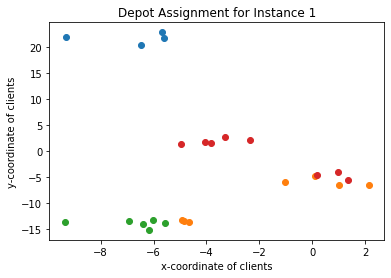

1 [0, 4, 18, 21, 23]
4 [1, 3, 5, 7, 13]
0 [2, 14, 22, 24]
3 [6, 10, 11, 12, 15, 17]
2 [8, 9, 16, 19, 20]


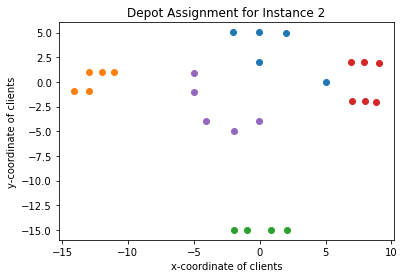

No Feasible Solution for instance 3


In [40]:
for k in data:
    q1(k)

### Q2

In [93]:
def q2(instance_id):
    # change date[i] to select the instance
    instance, d_max, n_min, n_max = data[instance_id]

    f = h5py.File(instance, 'r')
    X = np.transpose(f['X'])

    N = len(X)

    distances = {(client1, client2): dist(X[client1], X[client2]) for client1 in range(N) for client2 in range(client1+1, N)}
    pairings = {(client, depot): 0 for client in range(N) for depot in range(N)}

    # change the following variable and the corresponding ones in the while loop to n_min, n_max, d_max
    d_max = 0

    # change the while consition here to obtain different results
    while d_max <= 30:
        model = model1(N, d_max, n_min, n_max, pairings, distances)
        solveModel(model)
        minNumDepot, assignment = analyzeModel(model)

        plt.title('Depot Assignment for Instance %d (d_max = %d)' % (instance_id, d_max))
        for depot, clients in assignment.items():
            print(depot, clients)
            plt.xlabel('x-coordinate of clients')
            plt.ylabel('y-coordinate of clients')
            plt.scatter(X[clients][:, 0], X[clients][:, 1])

        plt.show()
        d_max += 1

    return 

In [96]:
# call q2 to see the results

# q2(3)